In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

In [2]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [3]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [4]:
def init_variables(all_data, o_bandit):
    bandit_rewards = pd.DataFrame(index=all_data.index)
    bandits = {'UCB_WAS': o_bandit}
    for bandit_k in bandits.keys(): 
        bandit_rewards[bandit_k] = np.nan
    bandit_rewards['oracle'] = np.nan
    for strat in strategies.keys():
        bandit_rewards[strat] = np.nan
    
    batch_times = list(all_data.index)
    # distances   = {bandit_k:{strat: [] for strat in strategies.keys()} for bandit_k in bandits.keys()}

    bandits_fin_info = {bandit_k:pd.DataFrame(index=all_data.index) for bandit_k in bandits.keys()}
    for bandit_k in bandits.keys(): 
        bandits_fin_info[bandit_k]['execPrice'] = np.nan
        bandits_fin_info[bandit_k]['S0']        = np.nan
        bandits_fin_info[bandit_k]['ST']        = np.nan
        bandits_fin_info[bandit_k]['twapPrice'] = np.nan
        
    return bandit_rewards, bandits_fin_info, batch_times

# Load Data & Signals

In [5]:
asset_name = 'BIDU'

In [6]:
all_data = None
for filename in os.listdir(f'../data/Rewards'):
    f = os.path.join(f'../data/Rewards', filename)
    # checking if it is a file
    if os.path.isfile(f):
        if asset_name in filename:
            trade_date = filename.split('_')[1]
            reward_fn = f'{asset_name}_{trade_date}_rewards.pkl'
            _all_data  = pd.read_pickle(f'../data/Rewards/{reward_fn}')
            _all_data  = _all_data[~_all_data.index.duplicated()].resample('1s').last().fillna(method='ffill')
            if all_data is None:
                all_data = _all_data 
            else:
                all_data = pd.concat((all_data, _all_data), axis=0)
all_data = all_data.sort_index()


In [7]:
all_data.tail(4).T


2022-12-23 15:59:54  2022-12-23 15:59:55  2022-12-23 15:59:56  2022-12-23 15:59:57
buyPrice_imbalance_1            111.610000           111.640000           111.595000           111.590000
buyPrice_MR                     111.610000           111.640000           111.595000           111.590000
buyPrice_TF                     111.640000           111.630000           111.600000           111.600000
sellPrice_imbalance_1           111.640000           111.630000           111.600000           111.600000
sellPrice_MR                    111.640000           111.630000           111.600000           111.600000
sellPrice_TF                    111.610000           111.640000           111.595000           111.590000
twapPrice                       111.645781           111.632500           111.597500           111.595682
S0                              111.610000           111.640000           111.595000           111.600000
ST                              111.640000           111.630000           111.600000           111.590000
mid_price                       111.610000           111.640000           111.595000           111.600000
imbalance_1                       0.476280             0.505595             0.037703            -0.430245
macd_120_260_90                  -2.580629             2.558445            -3.110456            -2.467753
macd_1200_2600_900               -0.003084            -0.002852            -0.004339            -0.004964
time_of_day                      16.000000            16.000000            16.000000            16.000000
macd_12_26_9                     -0.451209            -4.147247             0.324878             0.793387
TF                               -0.678774            -1.293726            -0.031979             0.943773
MR                               -0.678774            -1.293726            -0.031979             0.943773

In [8]:
# all_data
# all_data.buyPrice_TF.dropna()
# all_data

# GP bandits

In [9]:
from AOE.utils import verbose_print
from AOE.bandit_plots import hit_ratio_analysis, reward_distribution_analysis, regret_plots
from AOE.gp_bandit_finance import gp_bandit_finance, Wasserstein_GP_mean#, Wasserstein_GP
from AOE.plots import rescale_plot

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [10]:
strategies  = {'imbalance_1' : {'name'             : 'imbalance_1',
                                     'params'           : {'feature_name'     : 'imbalance_1'},
                                     'contextual_params': {'feature_name'     : 'imbalance_1'}},

               'MR' : {'name'             : 'MR',
                                  'params'           : {'feature_name'     : 'MR'},
                                  'contextual_params': {'feature_name'     : 'MR'}},

               'TF' : {'name'             : 'TF',
                                  'params'           : {'feature_name'     : 'TF'},
                                  'contextual_params': {'feature_name'     : 'TF'}}
              }

In [11]:
features = all_data[[s for s in all_data.columns if (('buyPrice' not in s)&('sellPrice' not in s))]]

In [12]:
# Likelihood models & non stationarity params
likelihood              = gpytorch.likelihoods.GaussianLikelihood()
size_buffer             = 30 # in terms of number of rewards to sample from
size_buffer_2           = 30 # in terms of number of rewards to sample from
size_window             = 15 # for non statonarity
bandit_params = {'size_buffer': size_buffer_2, 
                 'size_window': size_window,
                 'threshold'  : 0.005,
                 'lambda'     : 0.6,
                 'delta'      : 0.1,} # Delta is bound on type 1 error

# Bandit objects
o_bandit = gp_bandit_finance(strategies, bandit_algo='UCB_WAS', likelihood=likelihood, 
                                         bandit_params=bandit_params, verbose=True)

# Other control parameters and variables

In [13]:
# variables for historical trading data
i_order                   = 0
nb_added_rewards          = 0
verbose_level             = 1
arrival_intensity         = 0.5
ref_price                 = 'twapPrice'
nb_orders                 = 0

In [14]:
import gpytorch
o_ = gpytorch.likelihoods.GaussianLikelihood()
o_.noise = 0.05
o_.noise

tensor([0.0500], grad_fn=<AddBackward0>)

# Trading simulation

In [15]:
def alpha(gamma, sigma, V, nu, dt):
    cosh_alpha_dt = 1 + (gamma * V * (dt*sigma)**2) / (4 * nu)
    return (1/dt) * np.arccosh(cosh_alpha_dt)

def q_star(x, q0, T, gamma, sigma, V, nu, dt):
    alpha_ = alpha(gamma, sigma, V, nu, dt)
    return q0 * np.sinh(alpha_*(T - x))/np.sinh(alpha_*T)

S0        = 100
sigma     = 5
V         = 15000000 #TransactionTape.set_index('time').traded_quantity.rolling('1h').sum().mean()
nu        = 10 # 0.1 dollar per contract for AC style.
gamma     = 10**1 #per dollar
T         = 5/60/24

timesteps = np.linspace(0, T, 100)
q0        = 100 #int(0.1 * V) # nb of shares to liquidate : 10% of total traded volume
dt        = T/100

In [16]:
programme_horizon = '5min'

np.random.seed(15)
i_start = int(np.random.rand(1)*(9*len(all_data)/10))

programme_data = all_data.iloc[i_start:].first(programme_horizon)

# Fill na exec prices accordingly
for col in programme_data.columns:
    if 'Price_' in col:
        programme_data[col].fillna(programme_data[ref_price], inplace=True)
        
bandit_rewards, bandits_fin_info, batch_times = init_variables(programme_data, o_bandit)
buysell          = 2*np.random.randint(0, 2, size=None, dtype=int) - 1


*******  None  *******
I received an order at None with quantity -1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: TF
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: TF
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: TF
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: TF
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategie

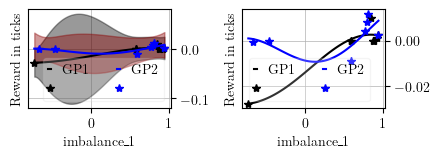

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00016  Threshold: 0.005
Average performance GP1: tensor(-0.0026, dtype=torch.float64)
Average performance GP2: tensor(0.0027, dtype=torch.float64)


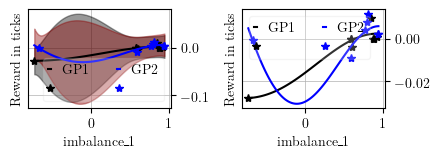

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.03043  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(0.0030, dtype=torch.float64)


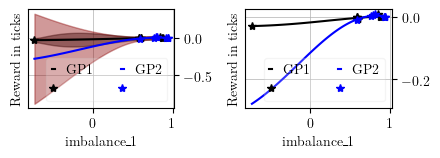

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Com

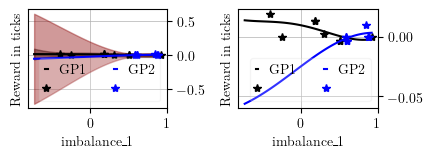

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserst

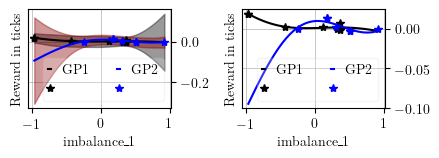

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00924  Threshold: 0.005
Average performance GP1: tensor(0.0049, dtype=torch.float64)
Average performance GP2: tensor(0.0031, dtype=torch.float64)


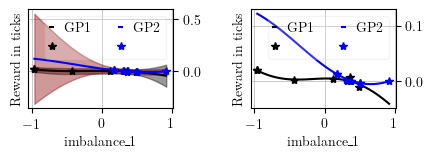

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : M

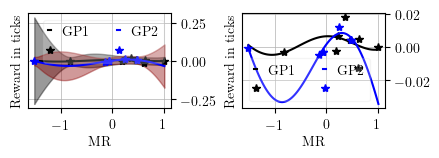

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.01079  Threshold: 0.005
Average performance GP1: tensor(0.0009, dtype=torch.float64)
Average performance GP2: tensor(0.0023, dtype=torch.float64)


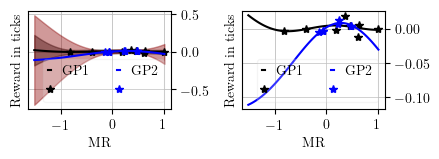

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR

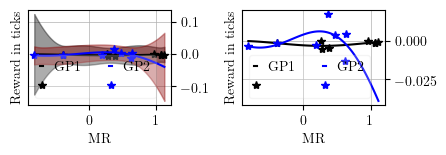

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00721  Threshold: 0.005
Average performance GP1: tensor(-0.0015, dtype=torch.float64)
Average performance GP2: tensor(0.0012, dtype=torch.float64)


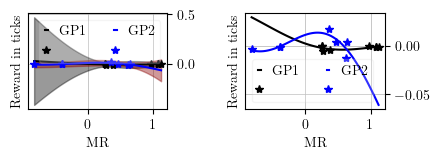

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle s

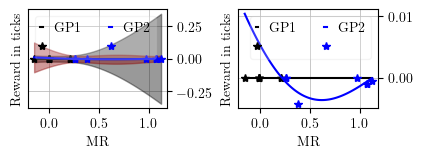

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00503  Threshold: 0.005
Average performance GP1: tensor(0., dtype=torch.float64)
Average performance GP2: tensor(-0.0004, dtype=torch.float64)


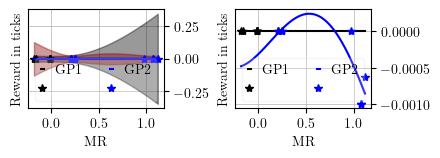

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected str

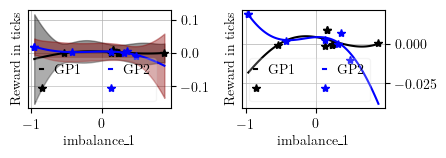

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00036  Threshold: 0.005
Average performance GP1: tensor(0.0019, dtype=torch.float64)
Average performance GP2: tensor(0.0046, dtype=torch.float64)


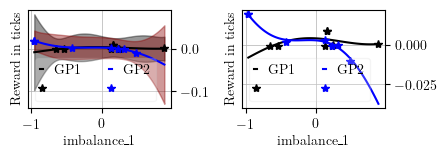

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00035  Threshold: 0.005
Average performance GP1: tensor(0.0019, dtype=torch.float64)
Average performance GP2: tensor(0.0041, dtype=torch.float64)


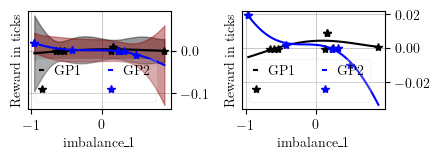

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00124  Threshold: 0.005
Average performance GP1: tensor(0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0042, dtype=torch.float64)


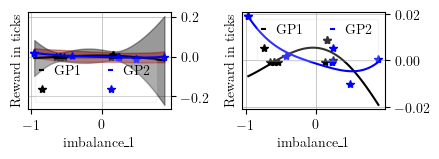

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00168  Threshold: 0.005
Average performance GP1: tensor(0.0010, dtype=torch.float64)
Average performance GP2: tensor(0.0052, dtype=torch.float64)


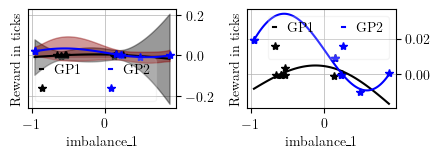

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00161  Threshold: 0.005
Average performance GP1: tensor(0.0004, dtype=torch.float64)
Average performance GP2: tensor(0.0037, dtype=torch.float64)


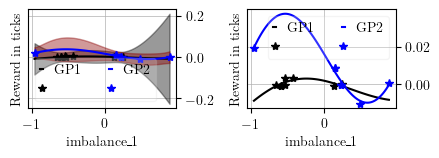

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00903  Threshold: 0.005
Average performance GP1: tensor(0.0003, dtype=torch.float64)
Average performance GP2: tensor(0.0008, dtype=torch.float64)


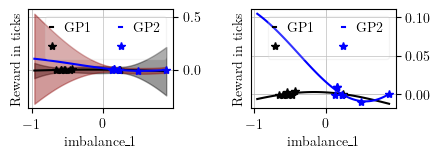

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for s

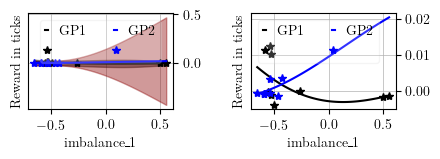

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00823  Threshold: 0.005
Average performance GP1: tensor(-3.2243e-05, dtype=torch.float64)
Average performance GP2: tensor(0., dtype=torch.float64)


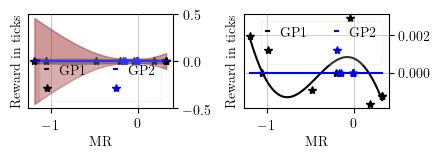

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: im

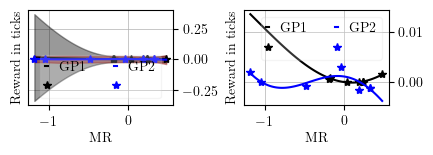

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00382  Threshold: 0.005
Average performance GP1: tensor(0.0004, dtype=torch.float64)
Average performance GP2: tensor(9.3021e-05, dtype=torch.float64)


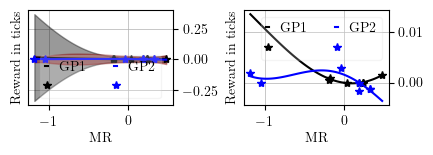

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00428  Threshold: 0.005
Average performance GP1: tensor(0.0003, dtype=torch.float64)
Average performance GP2: tensor(-0.0002, dtype=torch.float64)


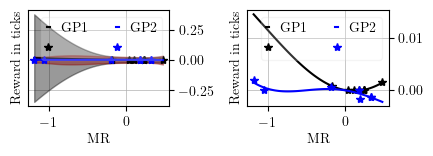

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00541  Threshold: 0.005
Average performance GP1: tensor(0.0001, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


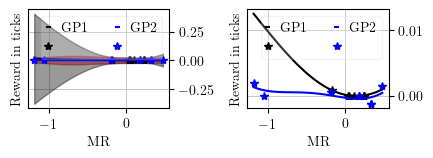

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: 

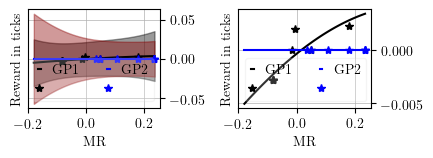

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  9e-05  Threshold: 0.005
Average performance GP1: tensor(-0.0010, dtype=torch.float64)
Average performance GP2: tensor(0., dtype=torch.float64)


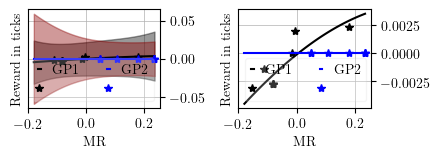

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  5e-05  Threshold: 0.005
Average performance GP1: tensor(-0.0012, dtype=torch.float64)
Average performance GP2: tensor(2.0301e-15, dtype=torch.float64)


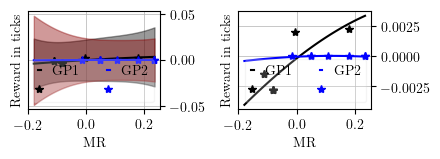

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.0001  Threshold: 0.005
Average performance GP1: tensor(-0.0015, dtype=torch.float64)
Average performance GP2: tensor(0.0003, dtype=torch.float64)


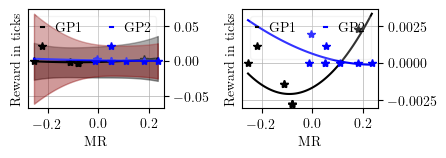

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00033  Threshold: 0.005
Average performance GP1: tensor(-0.0012, dtype=torch.float64)
Average performance GP2: tensor(0.0006, dtype=torch.float64)


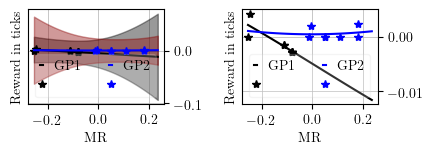

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


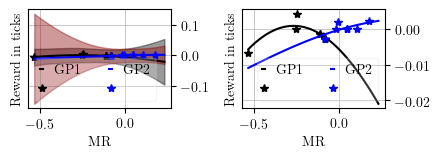

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


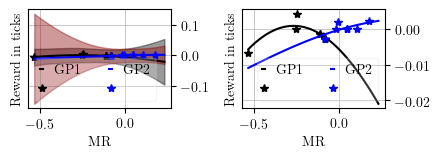

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


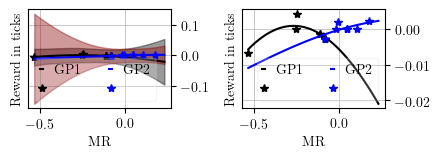

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


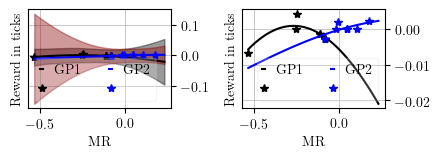

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00015  Threshold: 0.005
Average performance GP1: tensor(-0.0007, dtype=torch.float64)
Average performance GP2: tensor(0.0022, dtype=torch.float64)


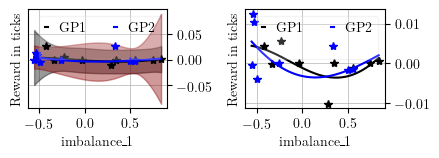

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


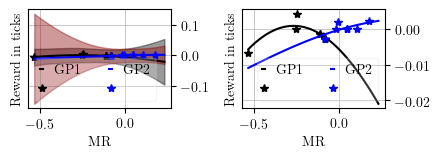

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00014  Threshold: 0.005
Average performance GP1: tensor(-0.0005, dtype=torch.float64)
Average performance GP2: tensor(0.0021, dtype=torch.float64)


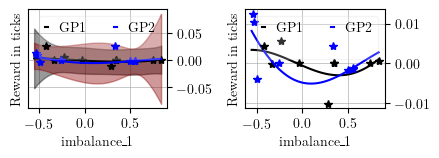

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


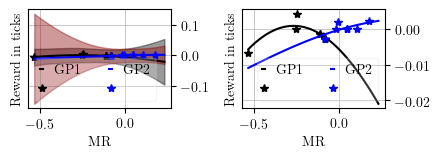

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00012  Threshold: 0.005
Average performance GP1: tensor(0.0019, dtype=torch.float64)
Average performance GP2: tensor(-0.0012, dtype=torch.float64)


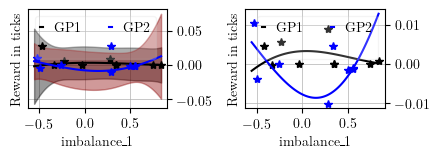

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


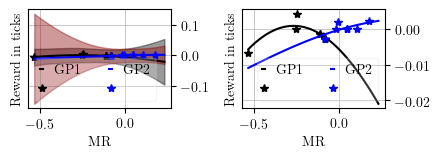

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  8e-05  Threshold: 0.005
Average performance GP1: tensor(0.0025, dtype=torch.float64)
Average performance GP2: tensor(-0.0006, dtype=torch.float64)


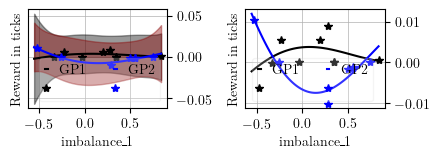

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


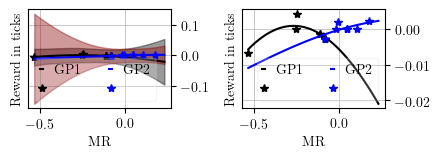

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00035  Threshold: 0.005
Average performance GP1: tensor(0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0020, dtype=torch.float64)


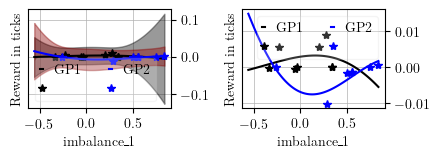

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


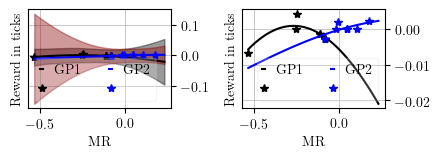

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00043  Threshold: 0.005
Average performance GP1: tensor(0.0027, dtype=torch.float64)
Average performance GP2: tensor(-0.0020, dtype=torch.float64)


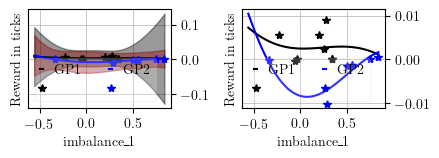

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


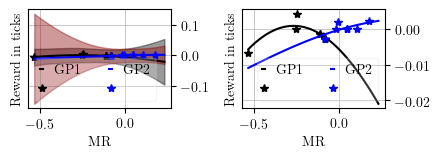

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.0011  Threshold: 0.005
Average performance GP1: tensor(0.0018, dtype=torch.float64)
Average performance GP2: tensor(-0.0010, dtype=torch.float64)


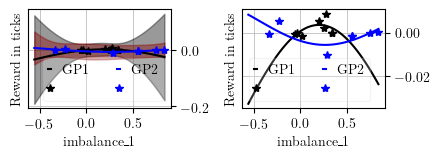

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


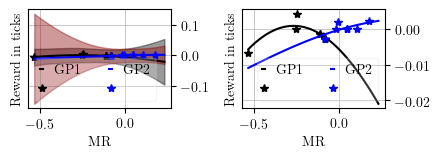

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00112  Threshold: 0.005
Average performance GP1: tensor(0.0029, dtype=torch.float64)
Average performance GP2: tensor(-0.0008, dtype=torch.float64)


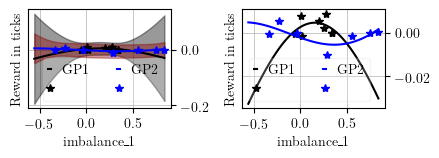

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


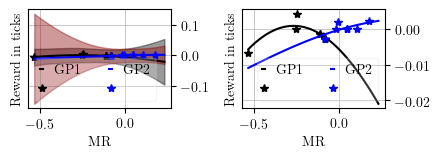

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00098  Threshold: 0.005
Average performance GP1: tensor(0.0029, dtype=torch.float64)
Average performance GP2: tensor(-0.0006, dtype=torch.float64)


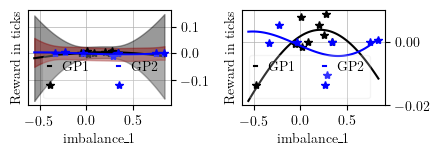

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


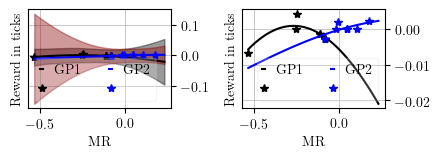

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00162  Threshold: 0.005
Average performance GP1: tensor(0.0019, dtype=torch.float64)
Average performance GP2: tensor(0.0008, dtype=torch.float64)


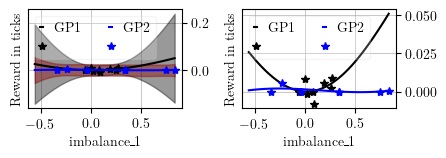

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


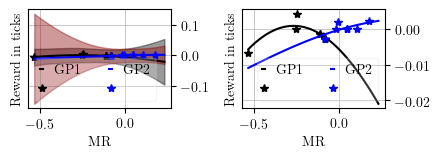

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00129  Threshold: 0.005
Average performance GP1: tensor(0.0005, dtype=torch.float64)
Average performance GP2: tensor(0.0021, dtype=torch.float64)


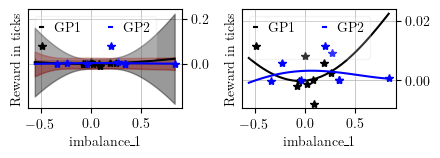

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


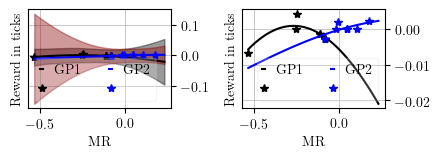

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00038  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(0.0028, dtype=torch.float64)


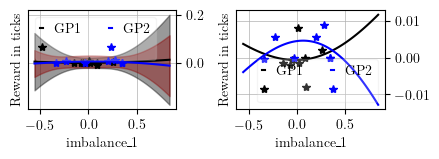

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


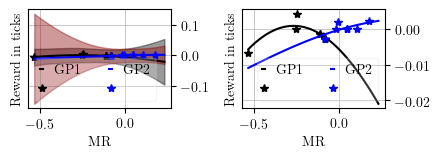

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00021  Threshold: 0.005
Average performance GP1: tensor(-0.0009, dtype=torch.float64)
Average performance GP2: tensor(0.0028, dtype=torch.float64)


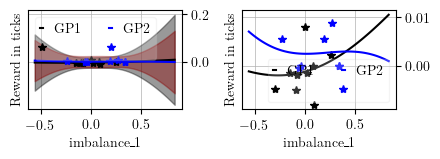

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


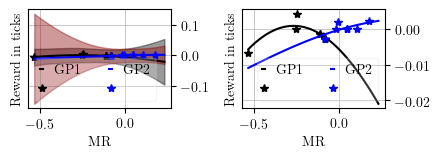

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00111  Threshold: 0.005
Average performance GP1: tensor(-0.0018, dtype=torch.float64)
Average performance GP2: tensor(0.0023, dtype=torch.float64)


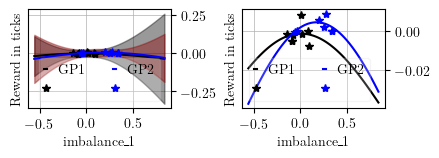

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


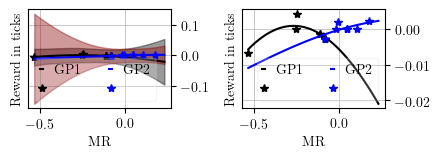

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00113  Threshold: 0.005
Average performance GP1: tensor(-0.0023, dtype=torch.float64)
Average performance GP2: tensor(0.0021, dtype=torch.float64)


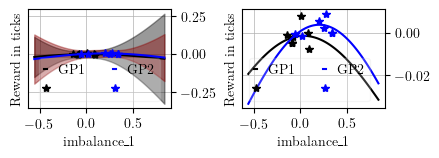

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


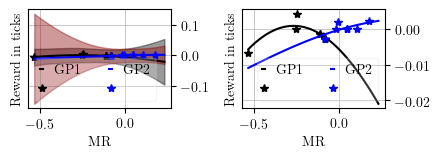

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00113  Threshold: 0.005
Average performance GP1: tensor(-0.0023, dtype=torch.float64)
Average performance GP2: tensor(0.0021, dtype=torch.float64)


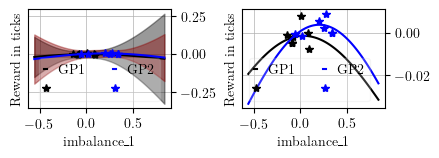

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


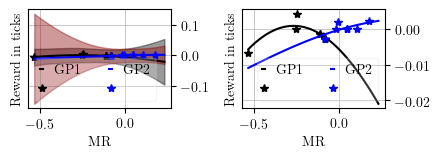

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00108  Threshold: 0.005
Average performance GP1: tensor(-0.0040, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


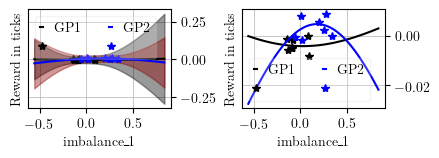

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


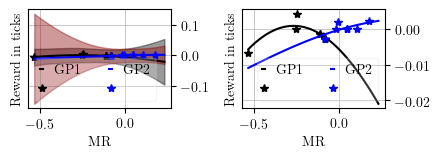

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00108  Threshold: 0.005
Average performance GP1: tensor(-0.0040, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


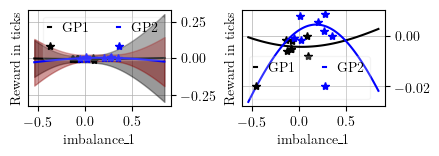

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


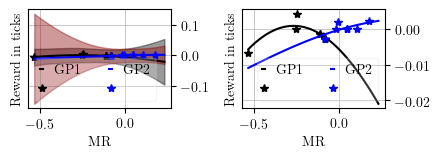

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00124  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


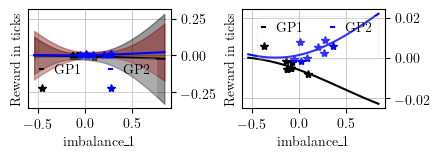

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


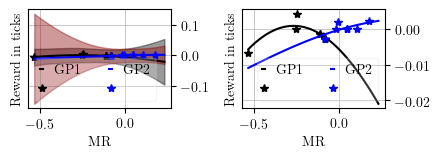

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


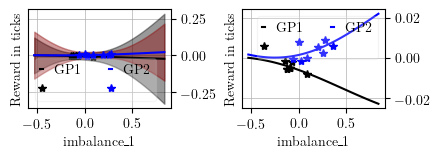

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00087  Threshold: 0.005
Average performance GP1: tensor(-0.0017, dtype=torch.float64)
Average performance GP2: tensor(0.0002, dtype=torch.float64)


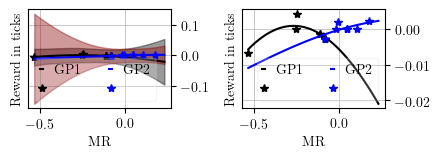

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


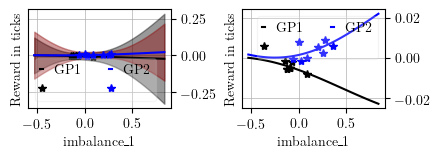

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.0008  Threshold: 0.005
Average performance GP1: tensor(-0.0016, dtype=torch.float64)
Average performance GP2: tensor(-0.0002, dtype=torch.float64)


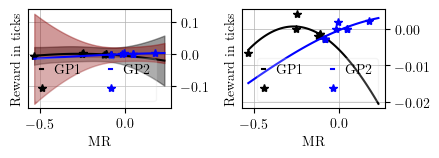

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


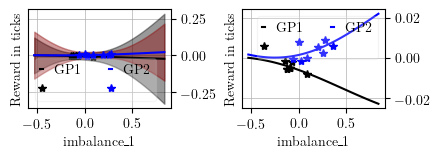

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00067  Threshold: 0.005
Average performance GP1: tensor(-0.0010, dtype=torch.float64)
Average performance GP2: tensor(-0.0006, dtype=torch.float64)


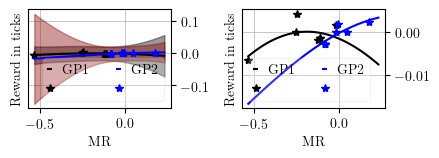

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


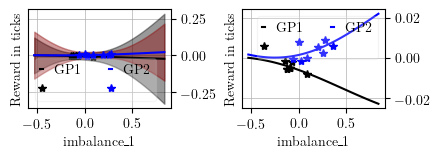

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00068  Threshold: 0.005
Average performance GP1: tensor(-0.0005, dtype=torch.float64)
Average performance GP2: tensor(-0.0010, dtype=torch.float64)


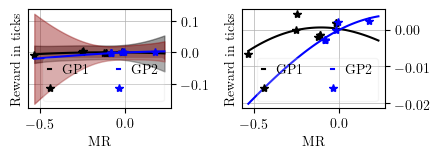

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


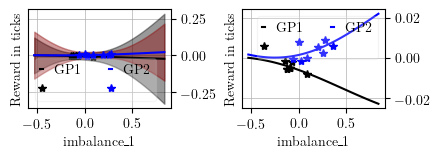

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.0006  Threshold: 0.005
Average performance GP1: tensor(-7.6730e-05, dtype=torch.float64)
Average performance GP2: tensor(-0.0012, dtype=torch.float64)


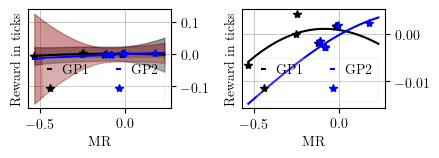

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


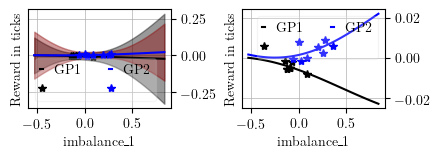

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.0006  Threshold: 0.005
Average performance GP1: tensor(-7.6730e-05, dtype=torch.float64)
Average performance GP2: tensor(-0.0017, dtype=torch.float64)


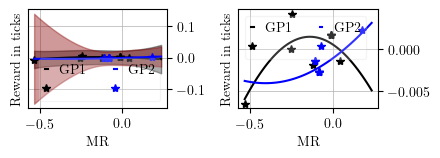

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


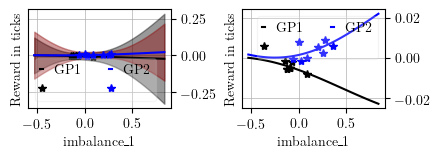

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00019  Threshold: 0.005
Average performance GP1: tensor(-0.0003, dtype=torch.float64)
Average performance GP2: tensor(-0.0020, dtype=torch.float64)


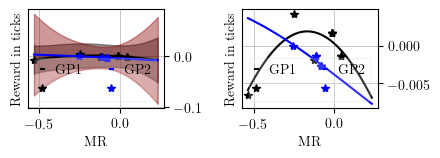

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


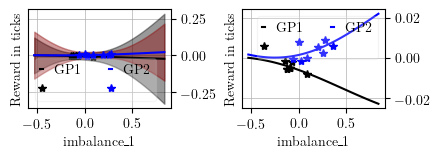

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00019  Threshold: 0.005
Average performance GP1: tensor(-0.0009, dtype=torch.float64)
Average performance GP2: tensor(-0.0010, dtype=torch.float64)


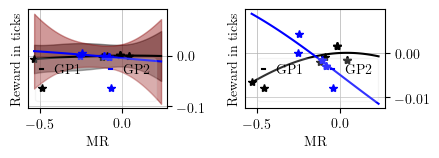

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


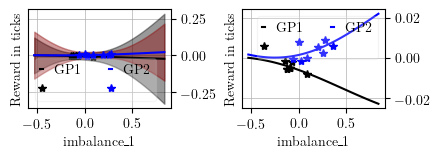

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00026  Threshold: 0.005
Average performance GP1: tensor(-0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0015, dtype=torch.float64)


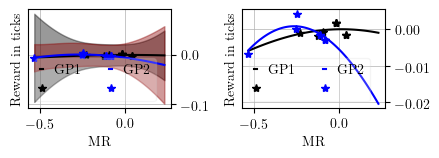

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


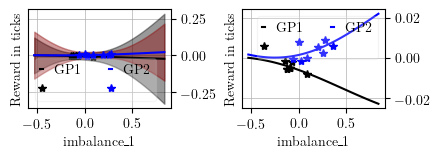

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00024  Threshold: 0.005
Average performance GP1: tensor(-6.5476e-05, dtype=torch.float64)
Average performance GP2: tensor(-0.0014, dtype=torch.float64)


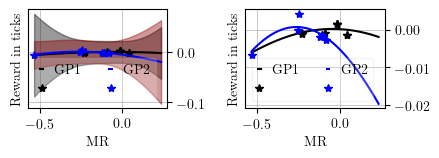

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


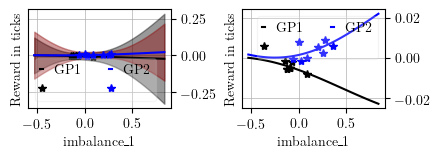

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00024  Threshold: 0.005
Average performance GP1: tensor(-6.5476e-05, dtype=torch.float64)
Average performance GP2: tensor(-0.0014, dtype=torch.float64)


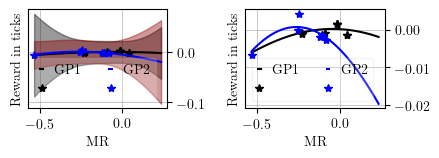

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


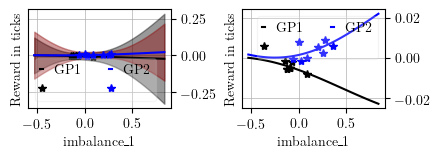

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00014  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0008, dtype=torch.float64)


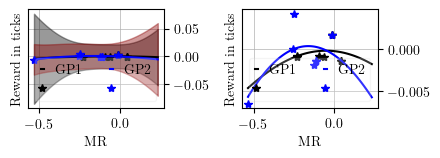

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


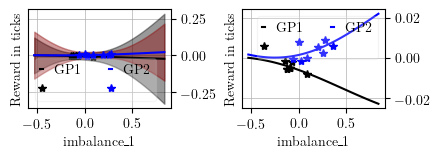

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00014  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0008, dtype=torch.float64)


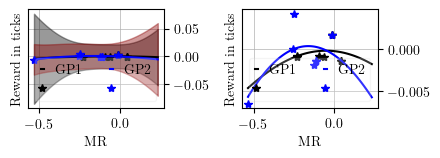

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


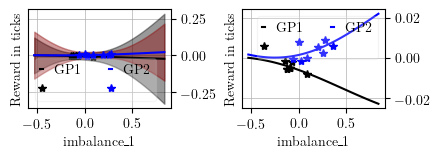

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00012  Threshold: 0.005
Average performance GP1: tensor(-0.0007, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


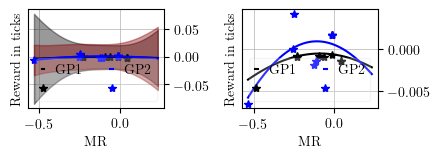

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


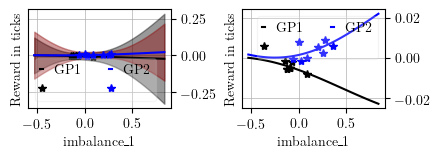

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00012  Threshold: 0.005
Average performance GP1: tensor(-0.0007, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


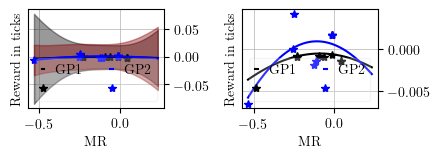

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


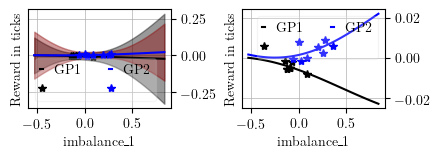

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00013  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(0.0001, dtype=torch.float64)


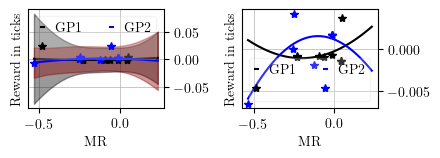

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


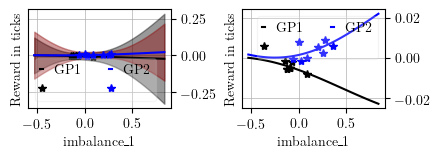

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00013  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(0.0001, dtype=torch.float64)


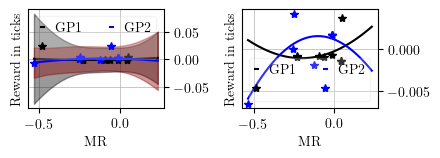

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


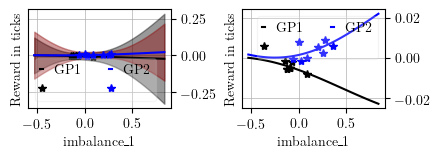

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00013  Threshold: 0.005
Average performance GP1: tensor(5.5060e-05, dtype=torch.float64)
Average performance GP2: tensor(-8.7691e-05, dtype=torch.float64)


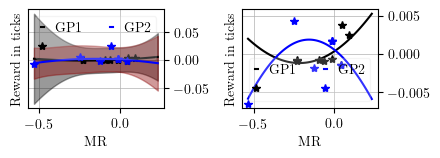

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


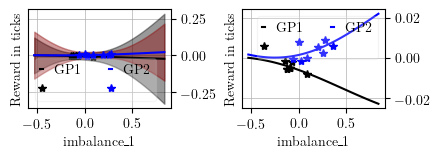

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00012  Threshold: 0.005
Average performance GP1: tensor(5.5060e-05, dtype=torch.float64)
Average performance GP2: tensor(-8.7691e-05, dtype=torch.float64)


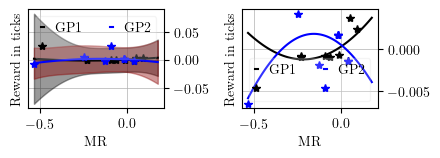

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


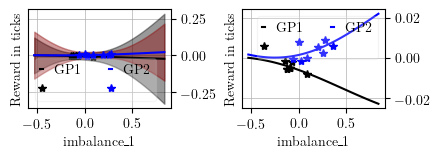

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00012  Threshold: 0.005
Average performance GP1: tensor(-0.0001, dtype=torch.float64)
Average performance GP2: tensor(-0.0009, dtype=torch.float64)


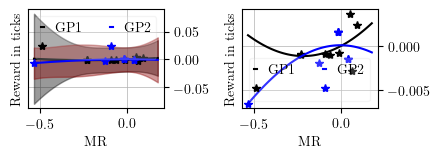

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


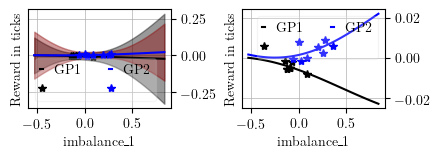

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00012  Threshold: 0.005
Average performance GP1: tensor(-0.0001, dtype=torch.float64)
Average performance GP2: tensor(-0.0009, dtype=torch.float64)


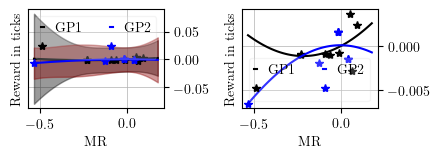

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


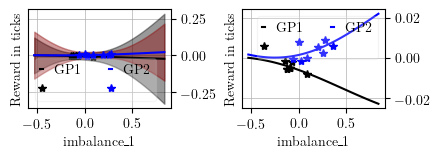

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00016  Threshold: 0.005
Average performance GP1: tensor(-9.7470e-05, dtype=torch.float64)
Average performance GP2: tensor(-8.0782e-05, dtype=torch.float64)


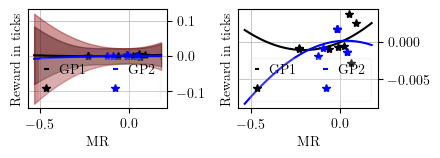

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


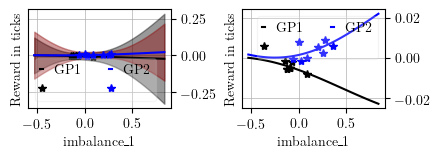

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00016  Threshold: 0.005
Average performance GP1: tensor(-9.7470e-05, dtype=torch.float64)
Average performance GP2: tensor(-8.0782e-05, dtype=torch.float64)


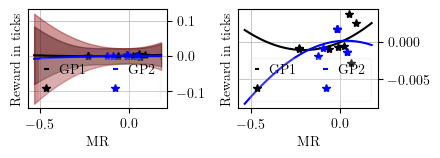

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


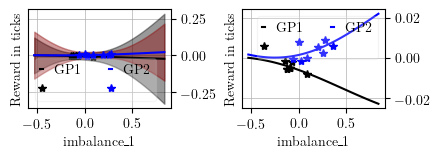

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  1e-05  Threshold: 0.005
Average performance GP1: tensor(-0.0002, dtype=torch.float64)
Average performance GP2: tensor(4.4218e-05, dtype=torch.float64)


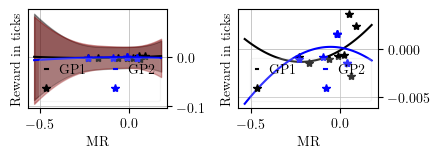

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


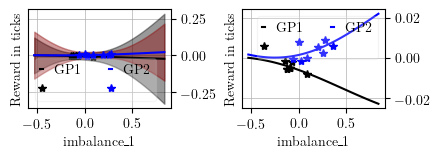

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  1e-05  Threshold: 0.005
Average performance GP1: tensor(-0.0002, dtype=torch.float64)
Average performance GP2: tensor(4.4218e-05, dtype=torch.float64)


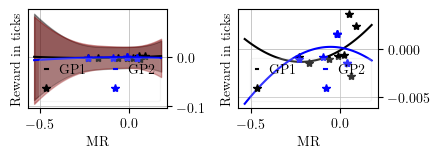

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


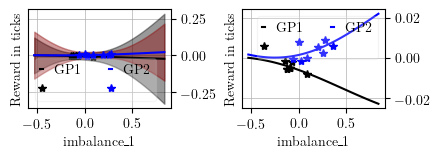

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  6e-05  Threshold: 0.005
Average performance GP1: tensor(-0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


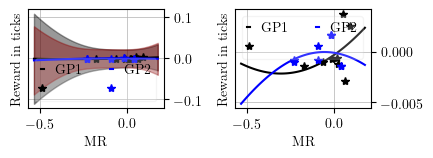

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


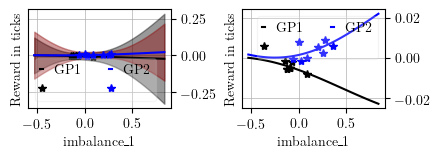

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  6e-05  Threshold: 0.005
Average performance GP1: tensor(-0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


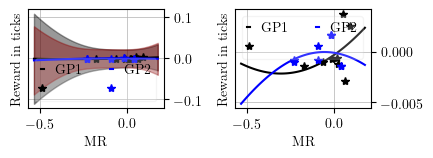

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


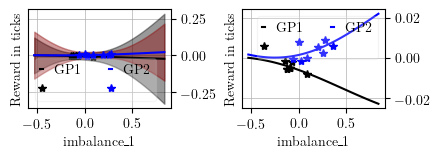

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  6e-05  Threshold: 0.005
Average performance GP1: tensor(0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0007, dtype=torch.float64)


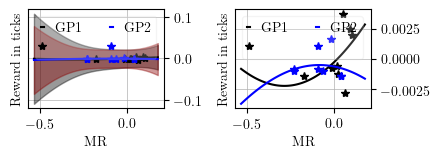

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


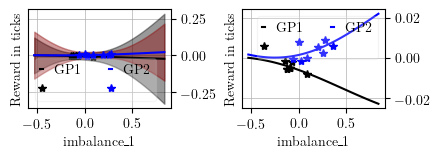

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  6e-05  Threshold: 0.005
Average performance GP1: tensor(0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0007, dtype=torch.float64)


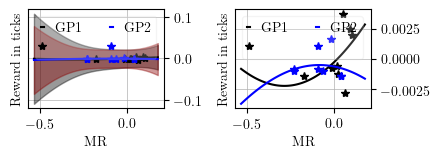

Computing UCB Waserstein for strategy: TF
Selected strategy: TF
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


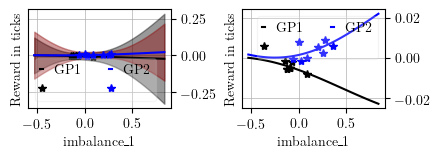

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  6e-05  Threshold: 0.005
Average performance GP1: tensor(0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0007, dtype=torch.float64)


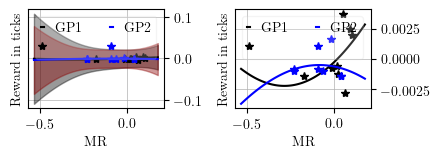

Computing UCB Waserstein for strategy: TF
Selected strategy: TF
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


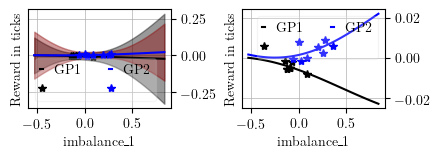

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  6e-05  Threshold: 0.005
Average performance GP1: tensor(0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0007, dtype=torch.float64)


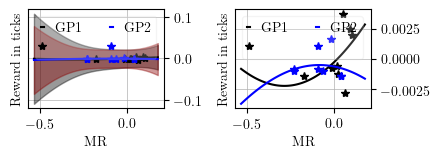

Computing UCB Waserstein for strategy: TF
Selected strategy: TF
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


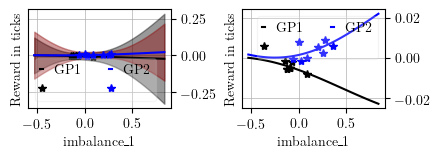

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  6e-05  Threshold: 0.005
Average performance GP1: tensor(0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0007, dtype=torch.float64)


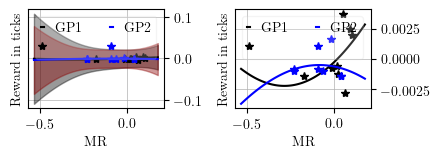

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


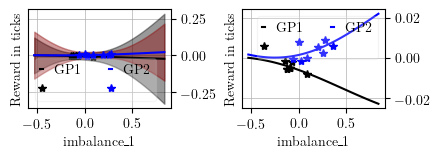

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.01577  Threshold: 0.005
Average performance GP1: tensor(0.0003, dtype=torch.float64)
Average performance GP2: tensor(-0.0010, dtype=torch.float64)


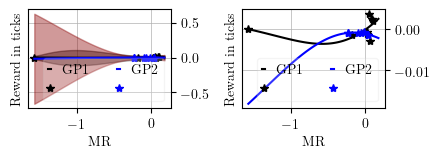

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


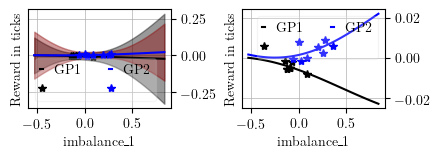

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


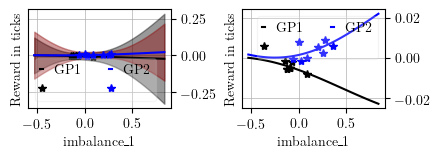

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


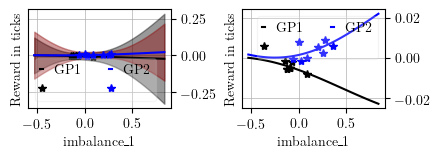

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


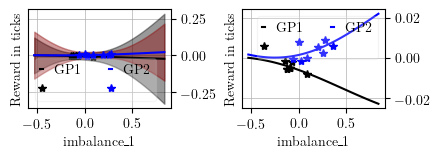

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


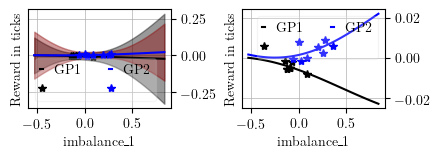

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


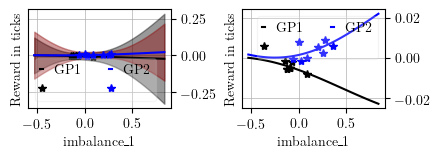

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: TF

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


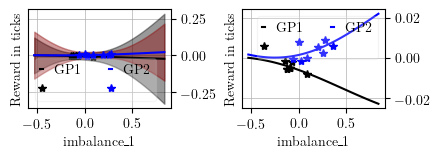

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


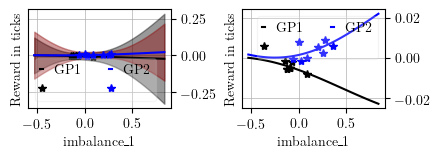

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00092  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0002, dtype=torch.float64)


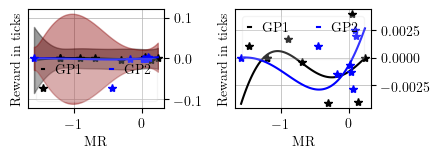

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


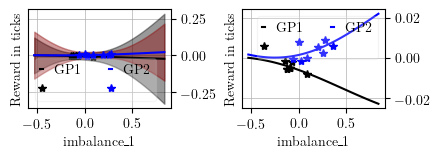

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00011  Threshold: 0.005
Average performance GP1: tensor(-0.0005, dtype=torch.float64)
Average performance GP2: tensor(-0.0006, dtype=torch.float64)


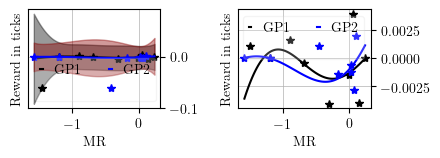

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


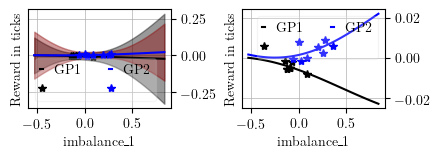

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00088  Threshold: 0.005
Average performance GP1: tensor(-0.0005, dtype=torch.float64)
Average performance GP2: tensor(-0.0002, dtype=torch.float64)


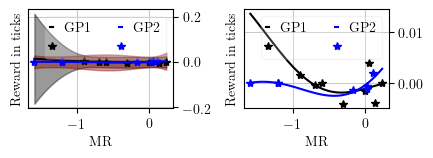

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


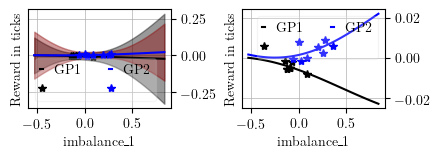

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00296  Threshold: 0.005
Average performance GP1: tensor(-0.0008, dtype=torch.float64)
Average performance GP2: tensor(0.0001, dtype=torch.float64)


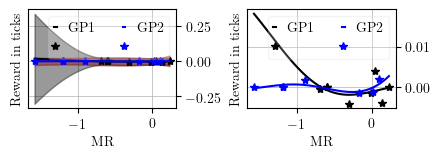

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


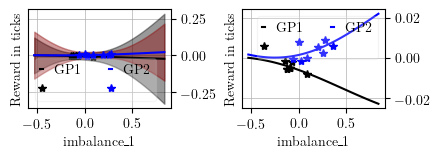

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00365  Threshold: 0.005
Average performance GP1: tensor(-0.0002, dtype=torch.float64)
Average performance GP2: tensor(-0.0002, dtype=torch.float64)


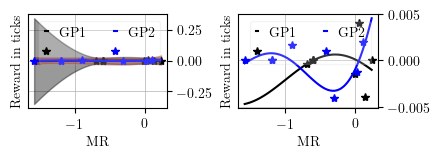

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


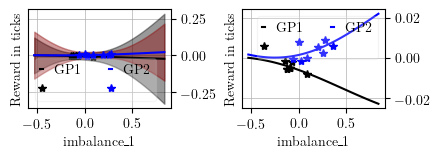

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.01025  Threshold: 0.005
Average performance GP1: tensor(0.0040, dtype=torch.float64)
Average performance GP2: tensor(-6.2925e-05, dtype=torch.float64)


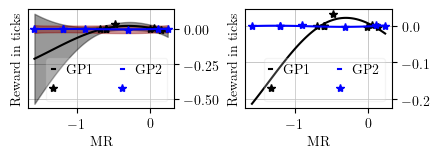

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00125  Threshold: 0.005
Average performance GP1: tensor(-0.0047, dtype=torch.float64)
Average performance GP2: tensor(0.0033, dtype=torch.float64)


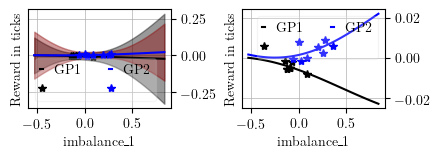

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.0009  Threshold: 0.005
Average performance GP1: tensor(-0.0035, dtype=torch.float64)
Average performance GP2: tensor(0.0008, dtype=torch.float64)


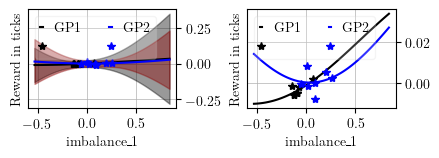

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.0009  Threshold: 0.005
Average performance GP1: tensor(-0.0035, dtype=torch.float64)
Average performance GP2: tensor(0.0008, dtype=torch.float64)


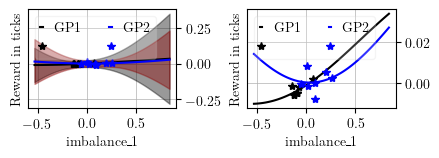

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00088  Threshold: 0.005
Average performance GP1: tensor(-0.0033, dtype=torch.float64)
Average performance GP2: tensor(-0.0002, dtype=torch.float64)


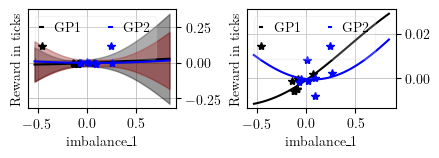

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00094  Threshold: 0.005
Average performance GP1: tensor(-0.0033, dtype=torch.float64)
Average performance GP2: tensor(-0.0002, dtype=torch.float64)


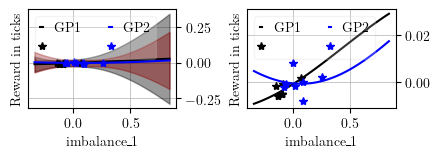

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00094  Threshold: 0.005
Average performance GP1: tensor(-0.0033, dtype=torch.float64)
Average performance GP2: tensor(-0.0002, dtype=torch.float64)


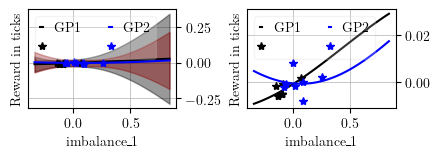

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.001  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


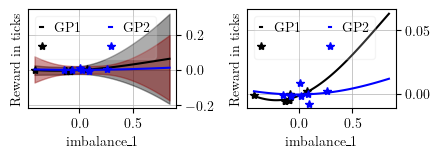

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.001  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


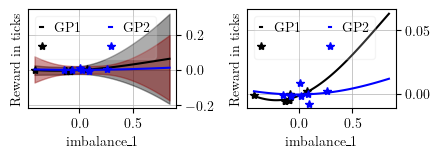

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.001  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


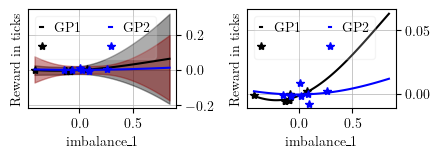

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.001  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


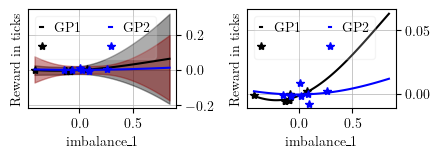

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.001  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


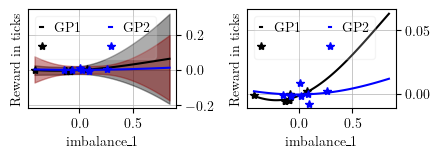

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.001  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


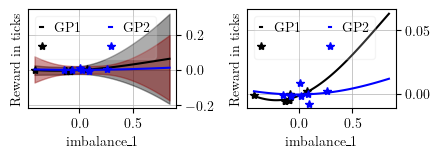

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.001  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


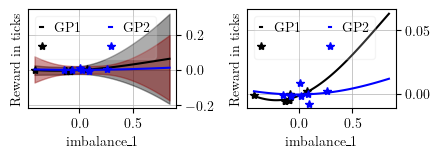

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.07348  Threshold: 0.005
Average performance GP1: tensor(0.0025, dtype=torch.float64)
Average performance GP2: tensor(0.0046, dtype=torch.float64)


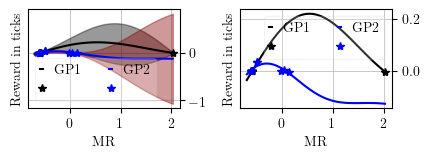

Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.001  Threshold: 0.005
Average performance GP1: tensor(-0.0032, dtype=torch.float64)
Average performance GP2: tensor(-0.0003, dtype=torch.float64)


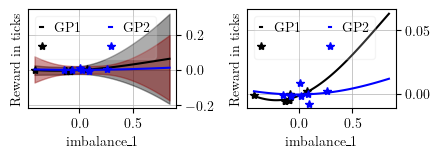

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00187  Threshold: 0.005
Average performance GP1: tensor(-0.0028, dtype=torch.float64)
Average performance GP2: tensor(-0.0014, dtype=torch.float64)


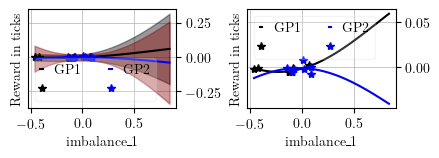

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00187  Threshold: 0.005
Average performance GP1: tensor(-0.0028, dtype=torch.float64)
Average performance GP2: tensor(-0.0014, dtype=torch.float64)


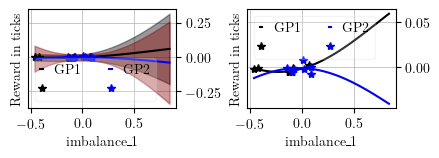

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


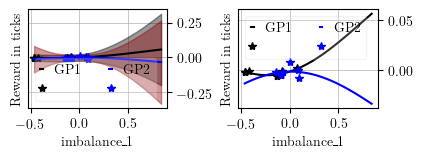

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


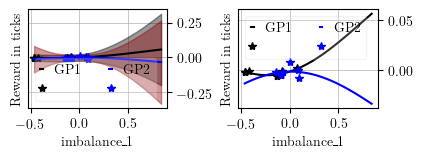

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


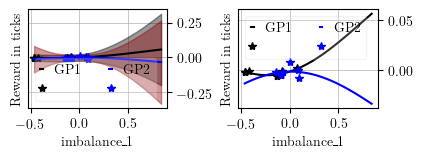

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


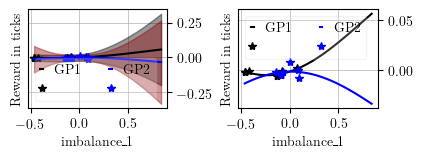

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


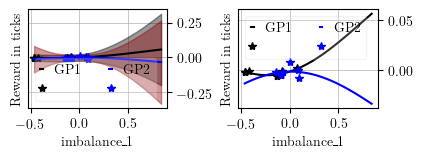

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


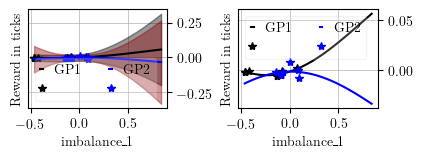

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


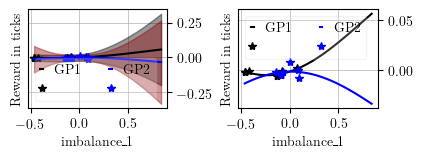

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


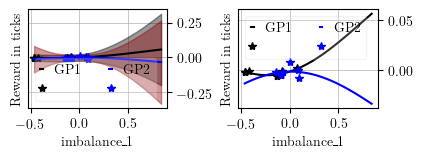

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


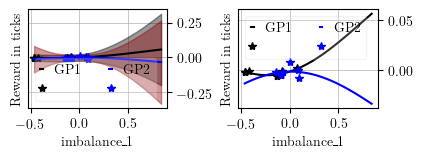

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


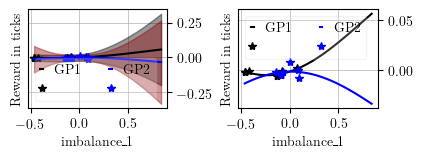

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.05524  Threshold: 0.005
Average performance GP1: tensor(0.0012, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


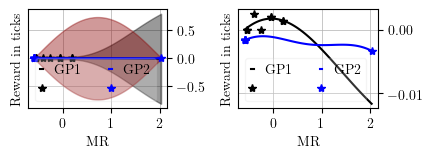

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


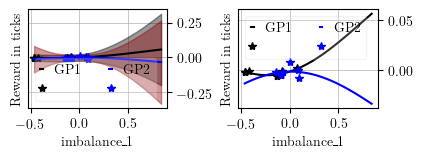

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


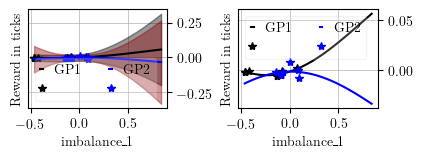

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


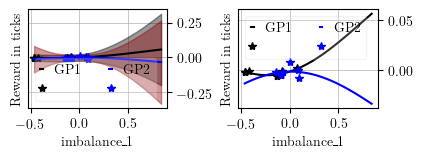

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


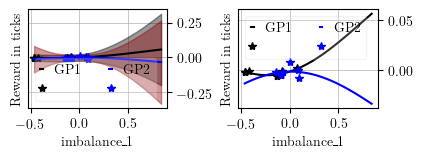

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


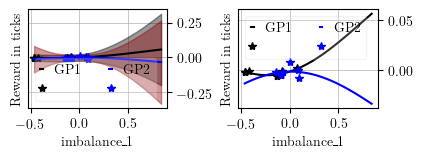

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


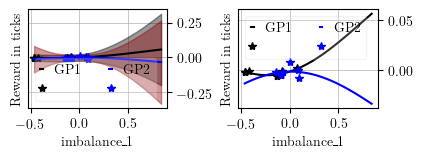

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


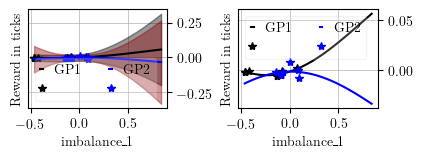

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


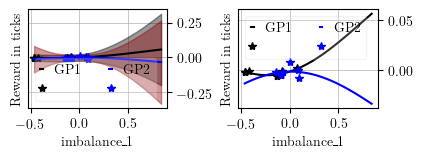

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00161  Threshold: 0.005
Average performance GP1: tensor(0., dtype=torch.float64)
Average performance GP2: tensor(0.0013, dtype=torch.float64)


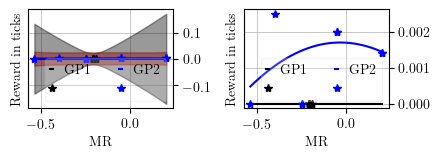

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


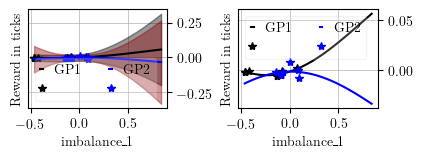

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00424  Threshold: 0.005
Average performance GP1: tensor(0., dtype=torch.float64)
Average performance GP2: tensor(0.0013, dtype=torch.float64)


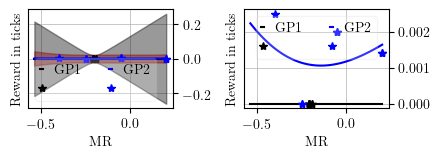

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


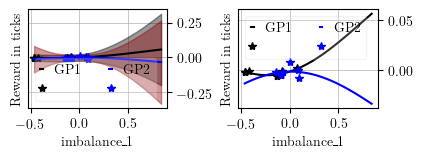

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00483  Threshold: 0.005
Average performance GP1: tensor(0., dtype=torch.float64)
Average performance GP2: tensor(0.0010, dtype=torch.float64)


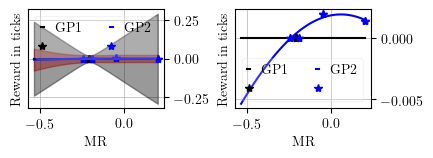

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


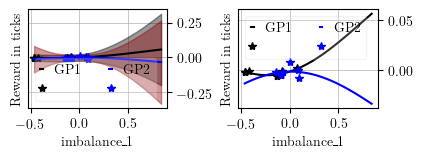

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.02497  Threshold: 0.005
Average performance GP1: tensor(0., dtype=torch.float64)
Average performance GP2: tensor(0.0007, dtype=torch.float64)


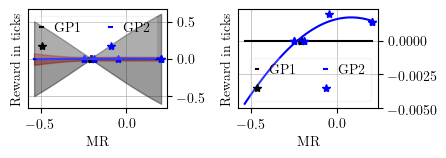

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


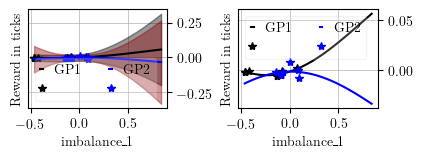

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


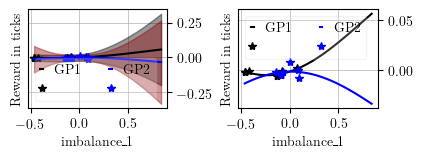

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


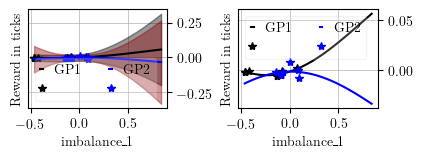

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


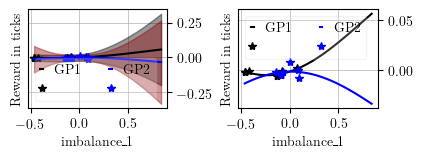

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


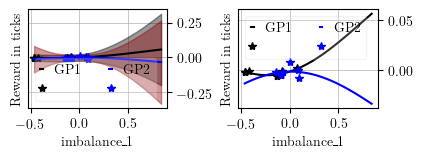

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


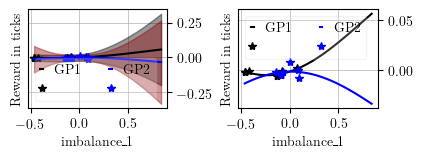

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


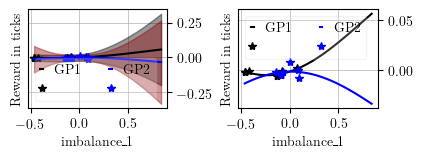

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


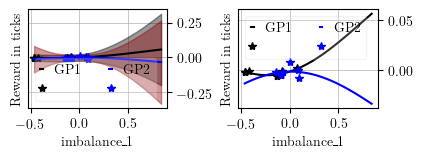

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.04267  Threshold: 0.005
Average performance GP1: tensor(0.0017, dtype=torch.float64)
Average performance GP2: tensor(0., dtype=torch.float64)


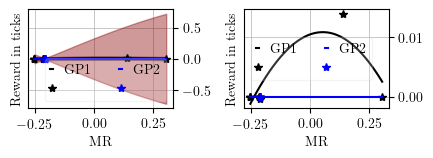

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


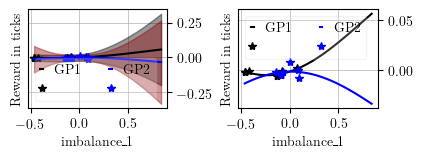

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


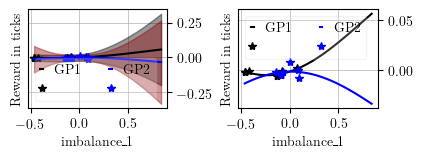

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


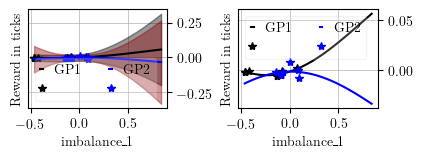

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


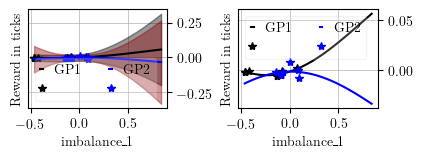

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


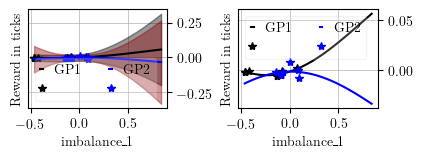

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


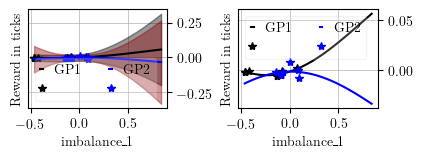

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


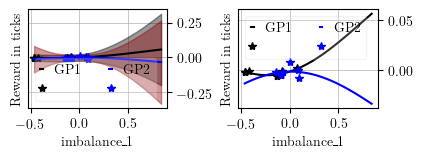

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


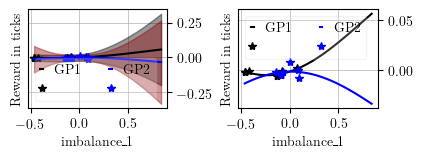

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.05295  Threshold: 0.005
Average performance GP1: tensor(0., dtype=torch.float64)
Average performance GP2: tensor(0.0019, dtype=torch.float64)


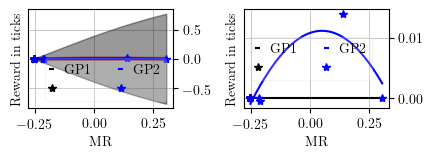

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


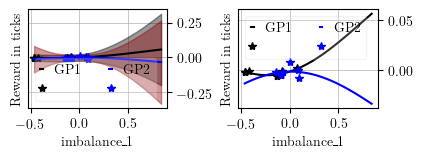

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


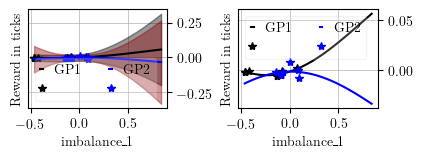

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


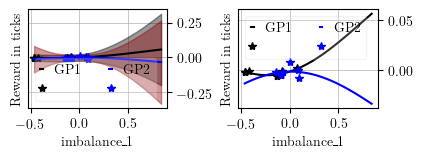

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


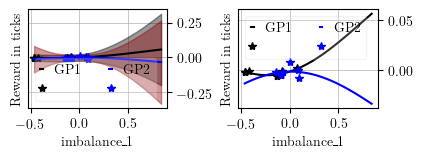

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


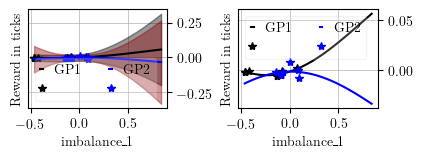

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


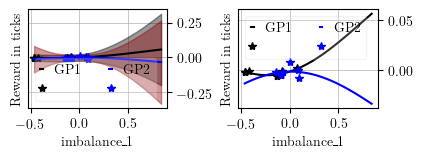

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


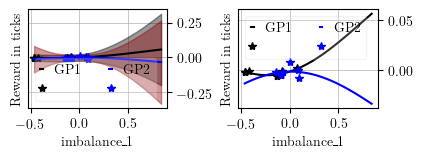

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


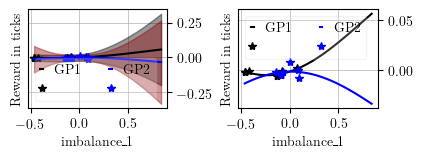

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.11186  Threshold: 0.005
Average performance GP1: tensor(0., dtype=torch.float64)
Average performance GP2: tensor(0., dtype=torch.float64)


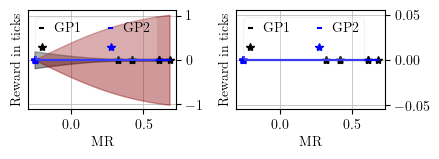

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


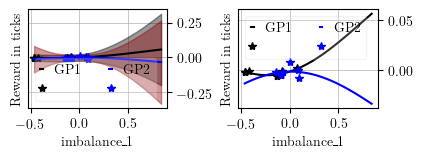

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


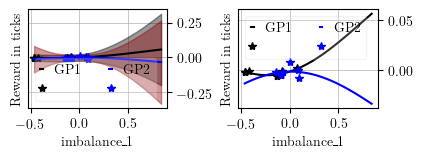

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00157  Threshold: 0.005
Average performance GP1: tensor(-0.0024, dtype=torch.float64)
Average performance GP2: tensor(-0.0019, dtype=torch.float64)


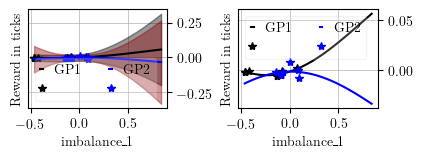

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00094  Threshold: 0.005
Average performance GP1: tensor(-0.0015, dtype=torch.float64)
Average performance GP2: tensor(-0.0037, dtype=torch.float64)


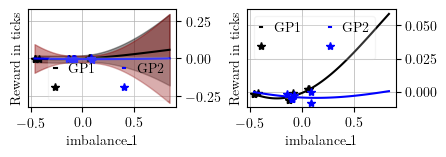

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00094  Threshold: 0.005
Average performance GP1: tensor(-0.0015, dtype=torch.float64)
Average performance GP2: tensor(-0.0037, dtype=torch.float64)


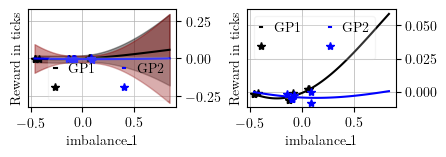

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: imbalance_1
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


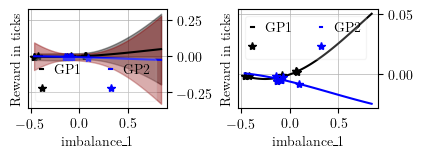

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


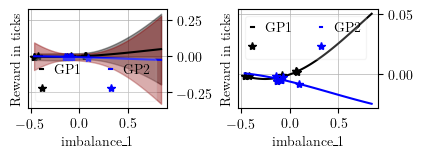

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


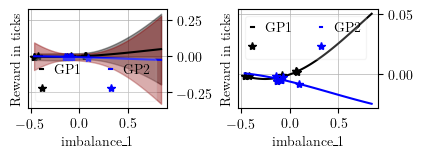

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


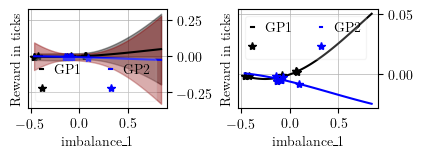

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


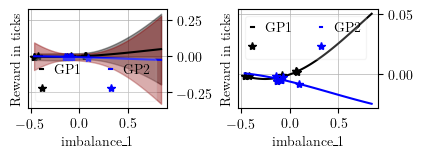

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


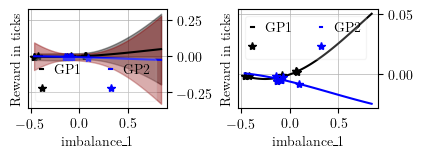

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.01128  Threshold: 0.005
Average performance GP1: tensor(0.0050, dtype=torch.float64)
Average performance GP2: tensor(0., dtype=torch.float64)


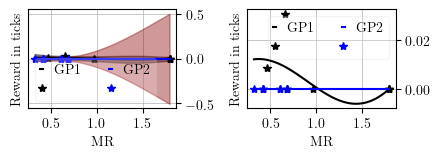

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


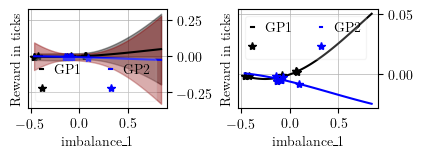

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


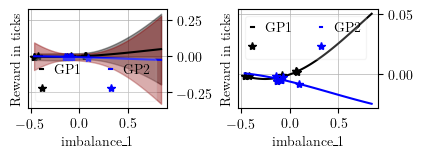

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


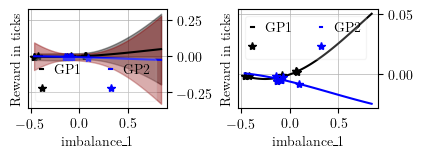

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


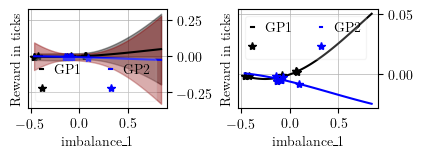

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


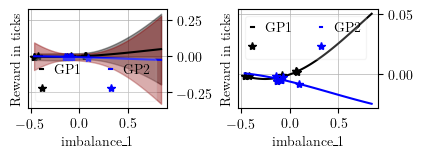

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


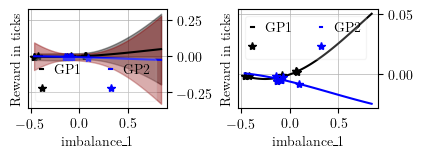

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


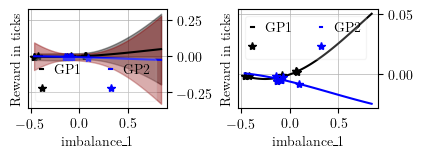

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


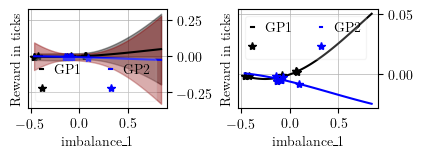

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.0218  Threshold: 0.005
Average performance GP1: tensor(0.0021, dtype=torch.float64)
Average performance GP2: tensor(0.0057, dtype=torch.float64)


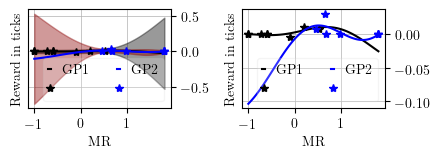

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


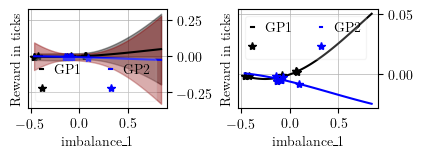

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


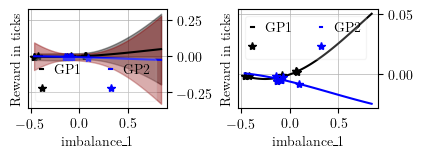

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


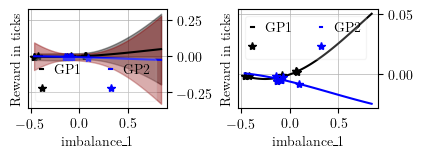

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


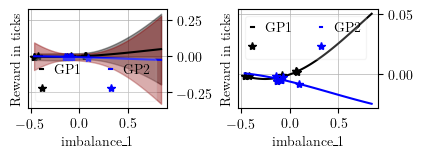

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


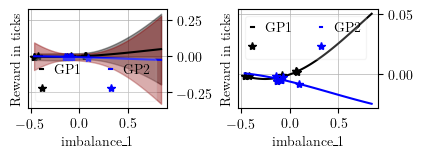

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


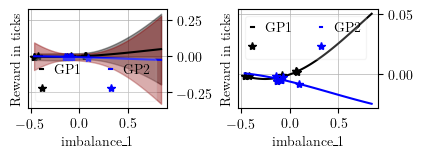

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


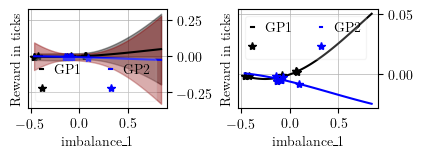

Computing UCB Waserstein for strategy: MR
Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


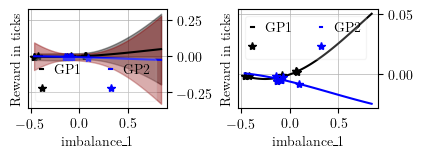

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  7e-05  Threshold: 0.005
Average performance GP1: tensor(0.0014, dtype=torch.float64)
Average performance GP2: tensor(0.0024, dtype=torch.float64)


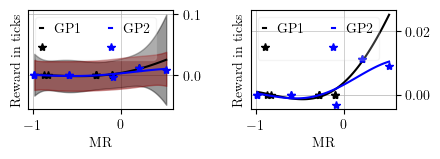

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


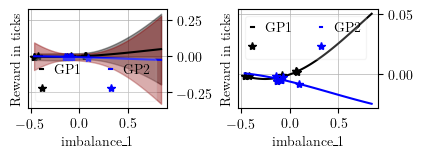

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00063  Threshold: 0.005
Average performance GP1: tensor(3.5527e-15, dtype=torch.float64)
Average performance GP2: tensor(0.0040, dtype=torch.float64)


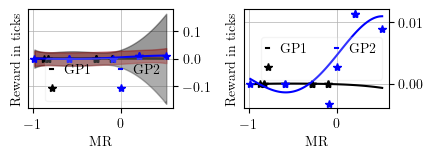

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


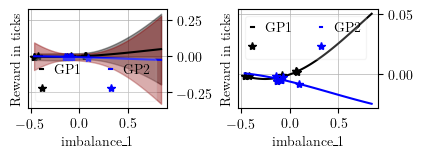

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00097  Threshold: 0.005
Average performance GP1: tensor(3.5527e-15, dtype=torch.float64)
Average performance GP2: tensor(0.0040, dtype=torch.float64)


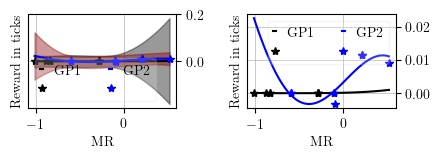

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


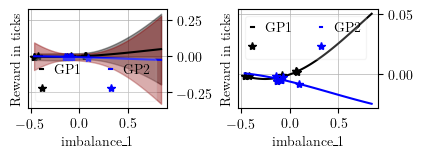

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00215  Threshold: 0.005
Average performance GP1: tensor(7.1054e-15, dtype=torch.float64)
Average performance GP2: tensor(0.0040, dtype=torch.float64)


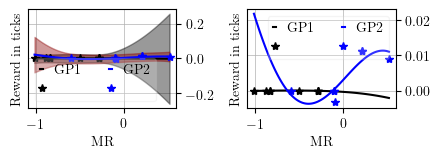

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


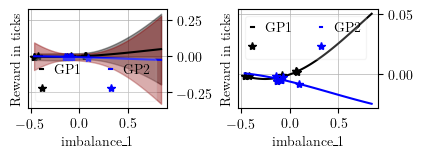

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00325  Threshold: 0.005
Average performance GP1: tensor(1.0658e-14, dtype=torch.float64)
Average performance GP2: tensor(0.0040, dtype=torch.float64)


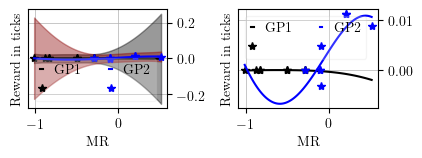

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


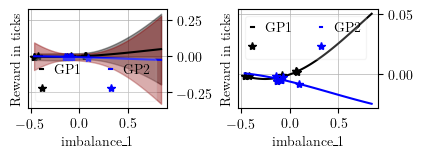

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00128  Threshold: 0.005
Average performance GP1: tensor(1.0658e-14, dtype=torch.float64)
Average performance GP2: tensor(0.0045, dtype=torch.float64)


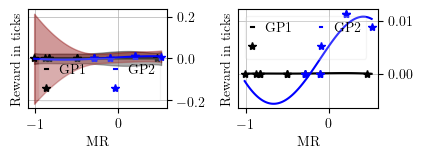

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


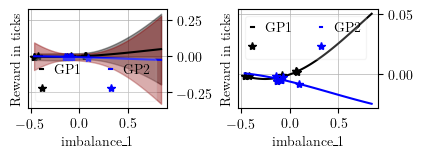

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00169  Threshold: 0.005
Average performance GP1: tensor(1.0658e-14, dtype=torch.float64)
Average performance GP2: tensor(0.0032, dtype=torch.float64)


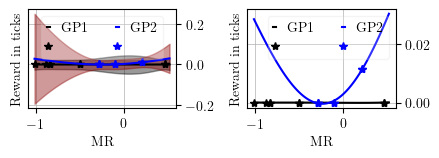

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: imbalance_1

 ** Bandit UCB_WAS: Selecting strategies ...
Computing UCB Waserstein for strategy: imbalance_1
** performing change point test for strategy : imbalance_1 **
Distance:  0.00145  Threshold: 0.005
Average performance GP1: tensor(-0.0004, dtype=torch.float64)
Average performance GP2: tensor(-0.0046, dtype=torch.float64)


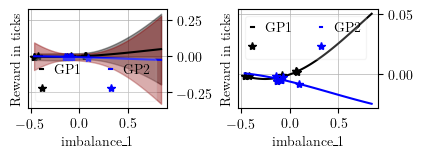

Computing UCB Waserstein for strategy: MR
** performing change point test for strategy : MR **
Distance:  0.00021  Threshold: 0.005
Average performance GP1: tensor(1.0658e-14, dtype=torch.float64)
Average performance GP2: tensor(0.0016, dtype=torch.float64)


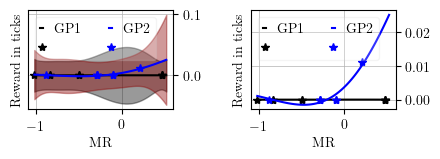

Computing UCB Waserstein for strategy: TF
Selected strategy: MR
Oracle strategy: MR


In [17]:
verbose_print(verbose_level, None, f'I received an order at {None} with quantity {buysell}', True)

q0     = 100*buysell
q      = np.zeros(len(batch_times)+1)
q[0]   = q0
dt     = T/len(batch_times)
bandit_k  = 'UCB_WAS'

rescale_plot(W=4.5, l=8, w=3)

for (i_time, batch_time) in enumerate(batch_times): # leave a few minutes
    # if np.random.poisson(arrival_intensity)>0:
    sigma       = 5
    q_cible     = q_star(T * i_time/len(batch_times), q0, T, 10**-3, sigma, V, nu, dt)
    trade_size  = int(q_cible - q[i_time])     
    q[i_time+1] = q[i_time]+trade_size
    V           = 15000000 #TransactionTape.set_index('time').traded_quantity.rolling('1h').sum().mean()
    nb_orders   += 1

    trade_date = str(batch_time).split(' ')[0]
    
    ###############################################
    # retrain GPs hyperparameters every N orders 
    ###############################################
    retrain_hyperparameters = True

    ##################################################
    # if an order arrives: decide if buy & sell
    ##################################################
    i_order          += 1

    ######################
    # get feature values
    ######################
    feature_values = features.loc[batch_time, :]

    ######################################
    # select the strategy for all bandits
    ######################################

    best_strategies_bandits = {}
    #for bandit_k in bandits.keys():
    verbose_print(verbose_level, batch_time, f'\n ** Bandit {bandit_k}: Selecting strategies ...')
    if i_time < 5*len(strategies): # at least 5 rewards before sampling
        best_strategies_bandits[bandit_k]  = random.choice(list(strategies.keys()))
    else:
        best_strategies_bandits[bandit_k]  = o_bandit.select_best_strategy(feature_values)
    verbose_print(verbose_level, batch_time, f'Selected strategy: {best_strategies_bandits[bandit_k]}')

    ######################################
    # Update & Retrain the GPs
    # & Non stationarity test
    ######################################
    tmp_pnls = {bandit_k:np.nan}
    
    #for bandit_k in bandits.keys():
    if buysell == 1:
        tmp_pnls[bandit_k] = -programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] + \
                    programme_data.loc[batch_time, ref_price]
    else:
        tmp_pnls[bandit_k] = programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] - \
                    programme_data.loc[batch_time, ref_price]

    #for bandit_k in bandits.keys():
        #print('Adding bandit : ', bandit_k, 'values are:', feature_values.MR, best_strategies_bandits[bandit_k], tmp_pnls[bandit_k])
    try:
        o_bandit.update_data(features  = feature_values, 
                                      strat     = best_strategies_bandits[bandit_k], 
                                      reward    = tmp_pnls[bandit_k],
                                      retrain_hyperparameters = retrain_hyperparameters)
    except Exception as e:
        retrain_hyperparameters = True
        print('Error while updating the bandit ', bandit_k ,': ', str(e), '\n', tmp_pnls[bandit_k])
        o_bandit.update_data(features  = feature_values, 
                                      strat     = best_strategies_bandits[bandit_k], 
                                      reward    = tmp_pnls[bandit_k],
                                      retrain_hyperparameters = False)
            #bandits[bandit_k].strat_gp_dict[best_strategies_bandits[bandit_k]].train()

    ######################################
    # Record rewards
    ######################################
    #for bandit_k in bandits.keys():
    if buysell == 1:
        bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                        programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] 
    else:
        bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                        programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] 

    bandit_rewards.loc[batch_time, bandit_k]               = tmp_pnls[bandit_k]
    bandits_fin_info[bandit_k].loc[batch_time,'S0']        = programme_data.loc[batch_time, 'S0'] 
    bandits_fin_info[bandit_k].loc[batch_time,'ST']        = programme_data.loc[batch_time, 'ST'] 
    bandits_fin_info[bandit_k].loc[batch_time,'twapPrice'] = programme_data.loc[batch_time, 'twapPrice'] 

    for strat in strategies.keys():
        if buysell == 1:
            bandit_rewards.loc[batch_time, strat] = \
                        -programme_data.loc[batch_time, f'buyPrice_{strat}'] + \
                        programme_data.loc[batch_time, ref_price]
        else:
            bandit_rewards.loc[batch_time, strat] = \
                        programme_data.loc[batch_time, f'sellPrice_{strat}'] - \
                        programme_data.loc[batch_time, ref_price]


    ##############################
    # Record oracle info
    ##############################
    oracle_strategy = bandit_rewards.loc[batch_time, strategies.keys()].idxmax() #(pnls_buy.loc[batch_time]).idxmax()
    bandit_rewards.loc[batch_time, 'oracle'] = bandit_rewards.loc[batch_time, f'{oracle_strategy}']
    verbose_print(verbose_level, batch_time, f"Oracle strategy: {oracle_strategy}")

# multiply pnls by trading speed
v = np.diff(q)
for i in range(len(bandit_rewards)):
    bandit_rewards.iloc[i,:] = np.abs(v[i]) * bandit_rewards.iloc[i,:]
    # regret_plots(strategies, rewards_to_plot.dropna(), programme_data,  bandits, W=5.5, figure_name = None)

UCB_WAS : 8.37 bps


/var/folders/h3/cyxpytps41d3jmsv99t0x7ww0000gn/T/ipykernel_23787/3827594753.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ax in (ax1, ax2, ax3): ax.grid(axis='both'); ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')


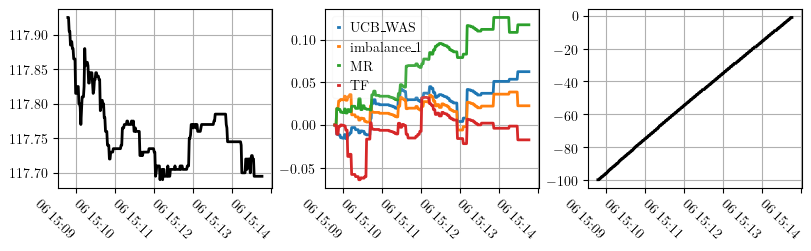

In [18]:
res_simulations = buysell, bandit_rewards, bandits_fin_info, q

# prepare the plot
rescale_plot(8, 10, 3)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, constrained_layout=True)

# plot programme prices
ax1.plot(programme_data.index, programme_data.mid_price, color='k', lw=2)

# get regrets & rewards
rewards_to_plot = pd.DataFrame(index=programme_data.index)

rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])

for (i_strat, strat) in enumerate(strategies.keys()):
    rewards_to_plot[strat]    = np.array(bandit_rewards[strat])
    
rewards_to_plot = rewards_to_plot.sort_index()
ax2.plot(rewards_to_plot.index, rewards_to_plot.dropna().cumsum(), lw=2)
ax2.legend(list(rewards_to_plot.columns), 
       loc='best', fancybox=True, framealpha=0.1, handlelength=0.1)
df_sim_results = res_simulations[1].dropna().cumsum().iloc[-1]  #pd.concat( (for i in res_simulations.keys()), axis=1).T
stats_sim = df_sim_results.describe().T
stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']

# Some printing
print( bandit_k, ':', round(10000 * stats_sim.loc['mean']/bandits_fin_info[bandit_k].execPrice.mean(), 2), "bps" )
ax3.plot(res_simulations[1].dropna().index, q[1:], color='k', lw=2) #np.linspace(len(res_simulations[i_simul][1].dropna()), 0, len(res_simulations[i_simul][1].dropna()))
for ax in (ax1, ax2, ax3): ax.grid(axis='both'); ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')
plt.show()

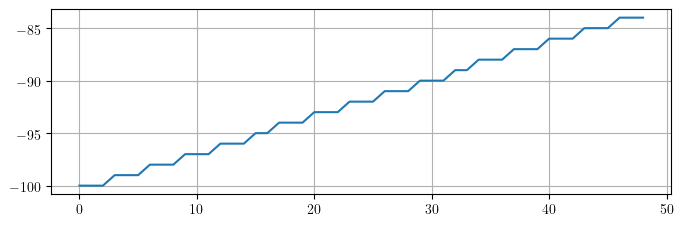

In [19]:
plt.plot(q[1:50])

plt.grid('both')

In [20]:
benchs    = ('twapPrice', S0, ST)

print('\n', '***********', bandit_k, '***********')
pnl_bandit = 0
pnl_twap   = 0
pnl_execS0 = 0
pnl_execST = 0
n          = len(res_simulations)


for i in range(n):
    tmp_bandit   = res_simulations[2][bandit_k].dropna()
    pnl_bandit   += tmp_bandit.execPrice.sum() - tmp_bandit[bench].sum()
    # pnl_twap     += tmp_bandit.twapPrice.sum() - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
    # pnl_execS0   += tmp_bandit.S0.sum()        - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
    # pnl_execST   += tmp_bandit.ST.sum()        - len(tmp_bandit)*tmp_bandit.iloc[0][bench]

print('PNL:', pnl_bandit/n)
# res_simulations[i][1]['TS_WAS'].dropna().S0.sum()

NameError: name 'ST' is not defined

In [ ]:
# fig, axes = plt.subplots(2, 3, sharey=True)
# for (i_i, bandit_k) in enumerate(bandits.keys()):
#     for (i_j, strat) in enumerate(strategies):
#         axes[i_i, i_j].plot(distances[bandit_k][strat])
#         axes[i_i, i_j].set_title(f'bandit {bandit_k}\n strat {strat}')
#         axes[i_i, i_j].grid(axis='both')
# plt.tight_layout()

# Regret analysis

In [ ]:
# get historical rewards and regret
rewards_to_plot = pd.DataFrame(index=all_data.index)
regrets_to_plot = pd.DataFrame(index=all_data.index)

for bandit_k in bandits.keys():
    regrets_to_plot[bandit_k] = - np.array(bandit_rewards[bandit_k]) + np.array(bandit_rewards['oracle'])
for (i_strat, strat) in enumerate(strategies.keys()):
    regrets_to_plot[strat]    = - np.array(bandit_rewards[strat]) + np.array(bandit_rewards['oracle'])

for bandit_k in bandits.keys():
    rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
for (i_strat, strat) in enumerate(strategies.keys()):
    rewards_to_plot[strat]    = np.array(bandit_rewards[strat])

regrets_to_plot = regrets_to_plot.sort_index()
rewards_to_plot = rewards_to_plot.sort_index()

### Hit ratio

In [ ]:
# (bandit_rewards.dropna()['UCB']==bandit_rewards.dropna()['oracle']).sum()/len(bandit_rewards.dropna())

In [ ]:
hit_ratio_analysis(rewards_to_plot, bandit_rewards['oracle'], bandits, _W = 5.5)

### Reward distributions

In [ ]:
for (clr, bandit_k) in zip(('k', 'tan', 'blue'), bandits.keys()):
    rewards_to_plot[bandit_k].hist(bins=30,  color=clr, alpha=0.4, density=True)

plt.legend(bandits.keys())

### Reward distributions in time

In [ ]:
period_est  = 20 # in number of rewards, can be "10min"
bandit_name = 'TS_WAS'

reward_distribution_analysis(bandit_name, bandits, period_est, all_data, rewards_to_plot.dropna(), bandit_rewards.dropna(),
                              strategies, W = 7, figure_name = None)

### Regret plots

In [ ]:
regret_plots(strategies, regrets_to_plot.dropna(), all_data,  bandits, W=5.5, figure_name = None)

In [ ]:
regret_plots(strategies, rewards_to_plot.dropna(), all_data,  bandits, W=5.5, figure_name = None)

### GP plot

In [ ]:
bandit_name  = 'TS_WAS'
bandits[bandit_name].plot_strategies()

In [ ]:
bandit_name  = 'UCB_WAS'
bandits[bandit_name].plot_strategies()

In [ ]:
rewards_to_plot